<a href="https://www.kaggle.com/code/clemwo/understanding-trees-in-depth?scriptVersionId=196479498" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 57.4 MB/s eta 0:00:00


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import Dash, html, dcc, callback, Output, Input

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification, load_iris, load_wine, load_diabetes
from sklearn.metrics import auc

import lightgbm
import xgboost
import xgboost as xgb
        
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/kaggle/input/drug-classification/drug200.csv


# 🤔Understanding Trees 🌳 In Depth💡

In this notebook we are going to investigate trained machine learning trees and their predictions in depth. For that matter we will use [Kaggle's Drug Classification](https://www.kaggle.com/datasets/prathamtripathi/drug-classification/data) dataset.

The dataset contains the following columns: 

| Column | Description | 
|:-------|:------------|
| `Age` | Age of the patient |
| `Sex` | Gender of the patient |
| `BP` | Blood pressure levels |
| `Cholesterol` | Cholesterol levels |
| `Na_to_K` | Sodium to potassium ratio in blood |
| `Drug` | Drug type |

In [3]:
drugs = pd.read_csv('/kaggle/input/drug-classification/drug200.csv')
print(f"Rows: {drugs.shape[0]:,}")
print(f"Cols: {drugs.shape[1]:,}")
drugs.head(3)

Rows: 200
Cols: 6


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC


# Global Settings

In [4]:
RANDOM_STATE = 42

# Pre-Processing

In [5]:
features = ['Age', 'Na_to_K']
target = None

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
categorical_columns = drugs.select_dtypes(include=['object']).columns

for col in categorical_columns:
    encoded_col_name = col + '_Encoded'
    drugs[encoded_col_name] = label_encoder.fit_transform(drugs[col])
    
    if 'Drug' not in encoded_col_name:
        features.append(encoded_col_name)
    else:
        target = encoded_col_name

print(f"Modelling features: {features}")
print(f"Modelling target  : {target}")
drugs.head(3)

Modelling features: ['Age', 'Na_to_K', 'Sex_Encoded', 'BP_Encoded', 'Cholesterol_Encoded']
Modelling target  : Drug_Encoded


,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Sex_Encoded,BP_Encoded,Cholesterol_Encoded,Drug_Encoded
0,23,F,HIGH,HIGH,25.355,DrugY,0,0,0,0
1,47,M,LOW,HIGH,13.093,drugC,1,1,0,3
2,47,M,LOW,HIGH,10.114,drugC,1,1,0,3


In [7]:
drugs['Drug_Encoded'].value_counts()

Drug_Encoded
0    91
4    54
1    23
3    16
2    16
Name: count, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(drugs[features], 
                                                    drugs[target], 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (160, 5)
X_test shape: (40, 5)
y_train shape: (160,)
y_test shape: (40,)


# Model Complexity Analysis

Every time a new tree is added to the model, we are essentially performing a new boosting round. The `tree_index` represents which round or tree we are looking at in the sequence of trees.

In [9]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split

In [10]:
xgb_params = {
    'max_depth': 3,                # maximum depth of each tree
    'eta': 0.1,                    # learning rate
    'objective': 'multi:softprob', # multiclass classification
    'eval_metric': 'mlogloss',     # evaluation metric for multiclass classification
    'num_class': 5                 # number of classes
}

xgb_clf = xgb.XGBClassifier(**xgb_params)
xgb_clf.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)], 
            verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, ...)

In [11]:
class BoostingComplexityAnalyzer:
    def __init__(self, model, classification_mode, n_classes=2):
        self.model = model
        self.classification_mode = classification_mode
        self.n_classes = n_classes
        self.tree_details = self._extract_tree_details()

    def _extract_tree_details(self):
        """Extracts tree details using model's `trees_to_dataframe` method."""
        return self.model.get_booster().trees_to_dataframe()

    def _compute_gain_attribution_by_feature(self):
        """Computes the relative gain contribution of each feature per tree."""
        self.tree_details['frac_of_total_split_gain'] = self.tree_details['Gain'] / self.tree_details['Gain'].sum()

In [12]:
analyzer = BoostingComplexityAnalyzer(xgb_clf, 
                                      classification_mode='multi', 
                                      n_classes=5)

__`frac_of_total_split_gain`__:

In decision tree-based models like Gradient Boosting or XGBoost, __split gain__ refers to the improvement in the model's objective function (e.g., a reduction in loss) when a node in a tree is split based on a particular feature.

The `frac_of_total_split_gain` is calculated as follows:

1. __Split Gain for a Feature__: For each tree, when a feature is used to split a node, it contributes a split gain to the overall model performance. The more useful the feature, the higher the gain.
2. __Total Split Gain__: The total split gain is the sum of the split gains across all features and all trees in the model.
3. __Fraction of Total Split Gain__: For each tree and each feature, the split gain of that feature is divided by the total gain for all features in the same tree, resulting in the fraction of total gain that the feature contributed in that tree.

$$
    \text{frac_of_total_split_gain} = \frac{\text{split_gain(feature, tree)}}{\text{total_gain(all_features, tree)}}
$$

> In simpler terms `frac_of_total_split_gain` tells us what percentage of the overall gain in the model is attributed to each feature in each boosting round (tree).

## Relative Gain Contribution Over Boosting Rounds

In this section we will visualize the relative gain contribution of each feature across boosting rounds (trees). We are going to use the `frac_of_total_split_gain` for each feature, showing how much each feature contributes to improving the model in every boosting round.

Mathematically, the relative gain contribution for each feature $𝑓$ at boosting round $t$ can be defined as:

$$
\text{frac_of_total_split_gain}(f, t) = \frac{\text{split_gain}(f, t)}{\sum_{f'} \text{split_gain}(f', t)}
$$

Where: 
- $\text{split_gain}(f, t)$ is the gain attributed to feature $f$ at boosting round $t$.
- $\sum_{f'} \text{split_gain}(f', t)$ is the total gain across all features $f'$ in boosting round $t$.

The metric `frac_of_total_split_gain` gives the fraction of total gain in a boosting round that is contributed by a specific feature, which helps to understand the importance of that feature at each step of the boosting process.

In [13]:
def plot_relative_gain(self):
    """Plots the relative contribution of each feature to total gain by boosting round."""
    self._compute_gain_attribution_by_feature()
    fig = px.line(data_frame=self.tree_details,
                  x="Tree",
                  y="frac_of_total_split_gain",
                  color="Feature",
                  title="Relative Contribution of Each Feature to Total Gain by Boosting Round",
                  labels={"frac_of_total_split_gain": "Relative Gain Contribution"})  
    fig.show() 
    
setattr(BoostingComplexityAnalyzer, 'plot_relative_gain', plot_relative_gain)

analyzer.plot_relative_gain()   

## Top $N$ Features by Relative Gain Contribution

In this section we visualize the relative gain contribution of the top $N$ features by selecting those that have the highest average contribution across all boosting rounds. Mathematically, we can break this down as follows: 

1. __Average Contribution__: For each feature $f$, the __average relative gain contribution__ across all boosting rounds $t$ is calculated as: 
$$
\text{avg_gain}(f) = \frac{1}{T} \sum_{t=1}^{T} \text{frac_of_total_split_gain}(f, t)
$$
Where: 
- $T$ is the total number of boosting rounds.
- $\text{frac_of_total_split_gain}(f, t)$ is the fraction of total split gain for feature $f$ in boosting round $t$.

2. __Selecting the Top $N$ Features__: The top $N$ features are selected based on the __highest average gain__:
$$
\text{top_features} = \text{argmax}_{f_1, f_2, \dots, f_n} \left( \text{avg_gain}(f_1), \dots, \text{avg_gain}(f_n) \right)
$$

3. __Relative Gain for Top $N$ Features__: Once the top $N$ features are selected, their __relative gain contribution__ over boosting rounds is plotted using: 
$$
\text{frac_of_total_split_gain}(f, t) = \frac{\text{split_gain}(f, t)}{\sum_{f'} \text{split_gain}(f', t)}
$$
Where $f$ is one of the top $N$ features.

In [14]:
def plot_top_n_relative_gain(self, top_n=5):
    """Plots the relative gain for the top N features."""
    self._compute_gain_attribution_by_feature()
    avg_gain = self.tree_details.groupby('Feature')['frac_of_total_split_gain'].mean()
    top_features = avg_gain.nlargest(top_n).index
    filtered_data = self.tree_details[self.tree_details['Feature'].isin(top_features)]
    fig = px.line(data_frame=filtered_data,
                  x="Tree",
                  y="frac_of_total_split_gain",
                  color="Feature",
                  title=f"Relative Contribution of Top {top_n} Features to Total Gain",
                  labels={"frac_of_total_split_gain": "Relative Gain Contribution"})
    
    fig.show()
    
setattr(BoostingComplexityAnalyzer, 'plot_top_n_relative_gain', plot_top_n_relative_gain)

analyzer.plot_top_n_relative_gain()   

Almost all of the relative gain contribution happens in the first few trees (e.g., within the first 50 boosting rounds), and then the contributions drop off sharply to almost zero.

## Heatmap of Feature Contribution

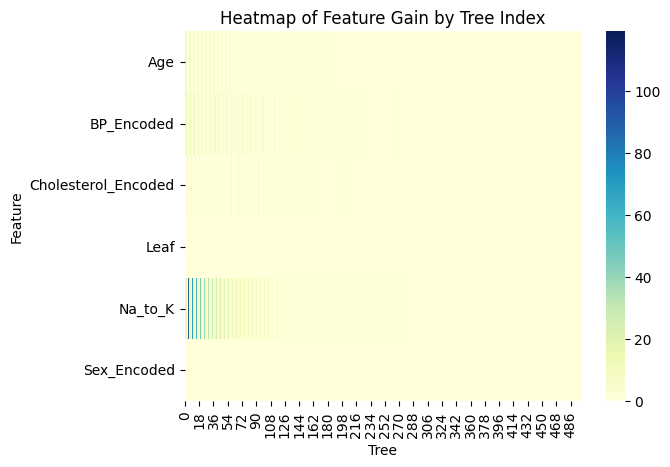

In [15]:
def plot_feature_gain_heatmap(self):
    """Plots heatmap of feature importance by tree index."""
    pivot_data = self.tree_details.pivot_table(index='Feature', columns='Tree', values='Gain', aggfunc='sum', fill_value=0)
    sns.heatmap(pivot_data, cmap="YlGnBu")
    plt.title("Heatmap of Feature Gain by Tree Index")
    plt.show()
    
setattr(BoostingComplexityAnalyzer, 'plot_feature_gain_heatmap', plot_feature_gain_heatmap)

analyzer.plot_feature_gain_heatmap()   

## Cumulative Contribution Plot

In [16]:
def plot_cumulative_feature_gain(self):
    """Plots the cumulative contribution of each feature to total gain over time."""
    self.tree_details['cumulative_gain'] = self.tree_details.groupby('Feature')['frac_of_total_split_gain'].cumsum()
    fig = px.line(data_frame=self.tree_details,
                  x="Tree",
                  y="cumulative_gain",
                  color="Feature",
                  title="Cumulative Contribution of Features to Total Gain",
                  labels={"cumulative_gain": "Cumulative Gain"})
    fig.show()
    
setattr(BoostingComplexityAnalyzer, 
        'plot_cumulative_feature_gain', 
        plot_cumulative_feature_gain)

analyzer.plot_cumulative_feature_gain()   

## Feature Importance Over Time (Combined with Split Count)

In [17]:
def plot_feature_importance_vs_split_count(self):
    """Plots feature importance vs. number of splits for each feature."""
    self.tree_details['split_count'] = self.tree_details.groupby('Feature')['Tree'].cumcount() + 1
    self.tree_details['scaled_gain'] = self.tree_details['frac_of_total_split_gain'].apply(lambda x: max(x, 0.001))  # Set a minimum value of 0.001 to avoid zero or negative sizes

    fig = px.scatter(
        data_frame=self.tree_details,
        x="split_count",
        y="frac_of_total_split_gain",
        color="Feature",
        size="scaled_gain",
        title="Feature Importance vs Split Count",
        labels={"split_count": "Number of Splits", "frac_of_total_split_gain": "Relative Gain Contribution"}
    )
    
    fig.show()
    
setattr(BoostingComplexityAnalyzer, 
        'plot_feature_importance_vs_split_count', 
        plot_feature_importance_vs_split_count)

analyzer.plot_feature_importance_vs_split_count()   

## ECDF

Number of features (backwards recursively eliminated) that sum to a percentage of a total model gain

Now we plot the ECDF of cumulative gain attribution by feature. As input we use the `feature_gain_by_tree_index`. In the following:
- __X-axis__: Represents the number of boosting rounds (tree indices) in the model. The model is gradually building trees, and each feature contributes differently to the cumulative gain over time.
- __Y-axis__: Cumulative fraction of total gain contributed by each feature. As the boosting rounds progress, the contribution of each feature to the overall model gain is accumulated, eventually summing to 1 (100%).

Each line corresponds to a feature (e.g., `Age`, `BP_Encoded`, `Cholesterol_Encoded`, etc.) and represents how much cumulative gain that feature has contributed over the number of boosting rounds.

In [18]:
def plot_ecdf_gain_attribution_by_feature(self):
    """Plots ECDF of cumulative gain attribution by feature."""
    self.tree_details['cumulative_frac_total_split_gain'] = self.tree_details.groupby('Feature')['frac_of_total_split_gain'].cumsum()
    fig = px.ecdf(data_frame=self.tree_details,
                  x="Tree",
                  y="cumulative_frac_total_split_gain",
                  color="Feature",
                  title="ECDF: Cumulative Gain Attribution by Feature",
                  labels={"cumulative_frac_total_split_gain": "Cumulative Fraction of Total Split Gain"})
    fig.show()
    
setattr(BoostingComplexityAnalyzer, 
        'plot_ecdf_gain_attribution_by_feature', 
        plot_ecdf_gain_attribution_by_feature)

analyzer.plot_ecdf_gain_attribution_by_feature()   

In [19]:
def plot_cumulative_features_used_by_estimator(self):
    """Plots the cumulative number of unique features used by tree."""
    unique_features = set()
    self.tree_details['cumulative_features_used'] = 0
    for i, row in self.tree_details.iterrows():
        unique_features.add(row['Feature'])
        self.tree_details.at[i, 'cumulative_features_used'] = len(unique_features)
    fig = px.line(data_frame=self.tree_details,
                  x="Tree",
                  y="cumulative_features_used",
                  title="Cumulative Features Used by Number of Estimators",
                  labels={"cumulative_features_used": "Cumulative Features Used"})
    fig.show()
    
setattr(BoostingComplexityAnalyzer, 
        'plot_cumulative_features_used_by_estimator', 
        plot_cumulative_features_used_by_estimator)

analyzer.plot_cumulative_features_used_by_estimator()   

In [20]:
def plot_new_unique_splits_by_feature(self):
    """Plots cumulative number of unique split thresholds by feature over boosting rounds."""
    
    # Track cumulative unique thresholds
    self.tree_details['n_unique_thresholds_seen'] = 0

    # Iterate over each feature and calculate the cumulative unique thresholds
    for feature in self.tree_details['Feature'].unique():
        feature_rows = self.tree_details[self.tree_details['Feature'] == feature]
        unique_thresholds = set()
        cumulative_counts = []
        for threshold in feature_rows['Split']:
            unique_thresholds.add(threshold)
            cumulative_counts.append(len(unique_thresholds))
        
        # Update with cumulative counts for this feature
        self.tree_details.loc[self.tree_details['Feature'] == feature, 'n_unique_thresholds_seen'] = cumulative_counts

    fig = px.line(data_frame=self.tree_details,
                  x="Tree",
                  y="n_unique_thresholds_seen",
                  color="Feature",
                  markers=True,
                  title="Cumulative No. of Unique Thresholds by Feature Over Time",
                  labels={"n_unique_thresholds_seen": "Cumulative Unique Splits"})
    
    fig.show()
    
setattr(BoostingComplexityAnalyzer, 
        'plot_new_unique_splits_by_feature', 
        plot_new_unique_splits_by_feature)

analyzer.plot_new_unique_splits_by_feature()   

## Expanding Tree Depth By Estimator

In [21]:
def plot_expanding_tree_depth_by_estimator(self):
    """Plots the expanding average tree depth by boosting round."""
    # Add a column to estimate the node depth based on the length of the Node index.
    self.tree_details['NodeDepth'] = self.tree_details['Node'].apply(lambda x: len(bin(x)) - 2)  # Bin length for depth

    # Now compute the maximum depth per tree
    max_depth_per_tree = self.tree_details.groupby('Tree')['NodeDepth'].max().expanding().mean()

    fig = go.Figure(go.Scatter(x=max_depth_per_tree.index, y=max_depth_per_tree, mode='lines'))
    fig.update_layout(
        title="Rolling Average of Tree Depth by Boosting Round", 
        xaxis_title="Tree Index", 
        yaxis_title="Rolling Avg Max Depth"
    )

    fig.show()
    
setattr(BoostingComplexityAnalyzer, 'plot_expanding_tree_depth_by_estimator', plot_expanding_tree_depth_by_estimator)

analyzer.plot_expanding_tree_depth_by_estimator()   

---

💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏